<a href="https://colab.research.google.com/github/srbray/PIC-Math-Workshop-on-Data-Science-2022/blob/main/Lithium_for_factor_importance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

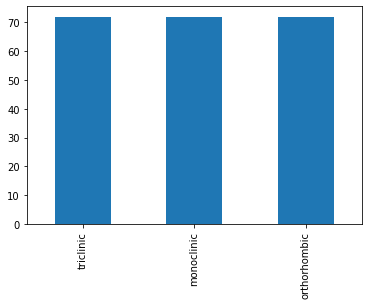

In [ ]:
# install package
# using for variable encoding

try:
    import chemparse
except:
    !pip install chemparse
    print('May need to restart kernel to use chemparse')

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px

url = 'https://raw.githubusercontent.com/rcpaffenroth/PIC-Math-Workshop-on-Data-Science-2022/main/data/lithium_ion_data.csv'
data = pd.read_csv(url)
data.sample(20)

#drop non-useful data
data.drop(columns=['Materials Id'],inplace=True)
data.columns

#Feature Engineering
# One-hot encode 'Has Bandstructure'
data['Has Bandstructure'] = data['Has Bandstructure'].map({True:1, False:0})


data['Formula'].value_counts()
# Option 4: use chemparse package to create the new features of atom counts
import chemparse
chem_data = data['Formula'].apply(chemparse.parse_formula)

# Convert the dictionary into a dataframe and fill NaN's with zero's
chem_data = pd.json_normalize(chem_data)
chem_data = chem_data.fillna(0)

data = data.join(chem_data)

# Encode Crystal System to ordinal values for multi-class problem
data['Crystal System (#)'] = data['Crystal System'].map({'monoclinic':0, 'orthorhombic':1, 'triclinic':2})

# All new numerical features (Crystal System excluded, since it's int32)
features = list(data.select_dtypes(include=['int64','float64']).columns.values)
labels = ['Crystal System (#)']

#Creating Balanced Data St
monoclinic_data=data[data['Crystal System'] == 'monoclinic']
orthorhombic_data=data[data['Crystal System'] == 'orthorhombic']
triclinic_data=data[data['Crystal System'] == 'triclinic']

monoclinic_data_sampled = monoclinic_data.sample(n=len(triclinic_data))
orthorhombic_data_sampled = orthorhombic_data.sample(n=len(triclinic_data))

data_rebalanced=triclinic_data.append(monoclinic_data_sampled).append(orthorhombic_data_sampled).reset_index(drop=True)

# Check for balance
data_rebalanced['Crystal System'].value_counts().plot(kind='bar')


In [ ]:
#Run Random Forest
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
train,test = train_test_split(data, test_size=0.2, shuffle=True, random_state=10)
X = data[features]
y = data[labels]
#80% training data and 20% testing
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2,shuffle=True, random_state=1)

# change to your selected model
model = RandomForestClassifier(n_estimators=100)


model.fit(Xtrain,ytrain)
yp4 = model.predict(Xtest)
    
titles4 = ['all but spacegroup']
accuracy=accuracy_score(yp4,ytest)

macro_precision=precision_score(yp4,ytest,average='macro')
micro_precision=precision_score(yp4,ytest,average='micro')

macro_recall=recall_score(yp4,ytest,average='macro')
micro_recall=recall_score(yp4,ytest,average='micro')

macro_f1=f1_score(yp4,ytest,average='macro')
micro_f1=f1_score(yp4,ytest,average='micro')

from tabulate import tabulate
results = [
["accuracy", accuracy],
["macro_precision", macro_precision],
["micro_precision",micro_precision],
["macro_recall",macro_recall],
["micro_recall",micro_recall],
["macro_f1",macro_f1],
["micro_f1",micro_f1],
] 
print (tabulate(results, headers=["Metrics", "Values"]))
#results.append([titles4[i],accuracy,macro_precision,micro_precision,macro_recall,micro_recall,macro_f1,micro_f1])
#print (tabulate(results, headers=["features", "accuracy", "macro_precision", "micro_precision", "macro_recall", "micro_recall", "macro_f1", "micro_f1"],tablefmt="grid"))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


Metrics            Values
---------------  --------
accuracy         0.985294
macro_precision  0.984848
micro_precision  0.985294
macro_recall     0.982456
micro_recall     0.985294
macro_f1         0.983239
micro_f1         0.985294


In [ ]:

# random forest for feature importance on a classification problem
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot

# define the model
model = RandomForestClassifier()
# fit the model
model.fit(X, y)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()